In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math
##TransformerEncoder  TransformerDecoder
# 加载数据
try:
    df = pd.read_csv('Beijing.csv')
except FileNotFoundError:
    print("错误：未找到 Beijing.csv 文件。请确保文件路径正确。")
    exit()

print("数据前5行:")
print(df.head())
print("\n数据后5行:")
print(df.tail())
print("\n数据基本信息:")
df.info()

# 计算每列的缺失值数量和百分比
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'缺失值数量': missing_values, '缺失值百分比': missing_percentage})
print("\n各列缺失值统计:")
print(missing_info)

数据前5行:
   year  month  day  hour  PM2.5   PM10   SO2   NO2   O3   CO  TEMP    PRES  \
0  2014      1    1     0   31.0  117.0  15.0  73.0  NaN  NaN  -0.4  1009.1   
1  2014      1    1     1   58.0  154.0  39.0  84.0  4.0  1.5  -1.1  1008.8   
2  2014      1    1     2   68.0  162.0  39.0  85.0  4.0  1.7  -1.4  1008.8   
3  2014      1    1     3   83.0  189.0  63.0  83.0  5.0  1.7  -2.4  1008.2   
4  2014      1    1     4   75.0  190.0  55.0  83.0  3.0  2.1  -2.5  1008.0   

   RAIN  HUMI  DEWP  WD   WS  
0   0.0  34.0 -14.4  NW  1.2  
1   0.0  40.0 -13.0  NW  1.2  
2   0.0  41.0 -13.0  SW  0.7  
3   0.0  46.0 -12.5  SE  0.6  
4   0.0  46.0 -12.6  CV  0.4  

数据后5行:
       year  month  day  hour  PM2.5   PM10   SO2    NO2    O3   CO  TEMP  \
17515  2015     12   31    19  112.0  112.0  28.0  114.0  23.0  2.3  -1.4   
17516  2015     12   31    20  122.0  132.0  27.0  118.0  26.0  3.2  -2.5   
17517  2015     12   31    21  149.0  179.0  30.0  125.0  31.0  4.5  -2.7   
17518  2015     

In [55]:
# 创建日期时间索引
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)
df.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)

In [56]:


# 1. 对所有数值列进行线性插值
# 挑选需要进行数值插补的列（所有数值类型的列）
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    # 确保所有列都是数值类型，非数值转为NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') 
    df[col].interpolate(method='linear', inplace=True)

# 2. 对分类变量（如风向WD）用众数填充
# 检查 'WD' 列是否存在并且该列有缺失值
if 'WD' in df.columns and df['WD'].isnull().any():
    # 使用该列的第一个众数来填充缺失值
    wd_mode = df['WD'].mode()[0]
    df['WD'].fillna(wd_mode, inplace=True)

# 3. 对插补后可能仍然存在的首尾缺失值进行填充
# 检查整个DataFrame是否还有任何缺失值
if df.isnull().any().any():
    # 使用前向填充
    df.fillna(method='ffill', inplace=True) 
    # 使用后向填充，确保万无一失
    df.fillna(method='bfill', inplace=True) 

print("\n插补后缺失值统计:")
print(df.isnull().sum())


插补后缺失值统计:
PM2.5    0
PM10     0
SO2      0
NO2      0
O3       0
CO       0
TEMP     0
PRES     0
RAIN     0
HUMI     0
DEWP     0
WD       0
WS       0
dtype: int64


/var/folders/82/tk3_mrrj641gqh1n1cbr4brr0000gn/T/ipykernel_34167/1823010718.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].interpolate(method='linear', inplace=True)
/var/folders/82/tk3_mrrj641gqh1n1cbr4brr0000gn/T/ipykernel_34167/1823010718.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

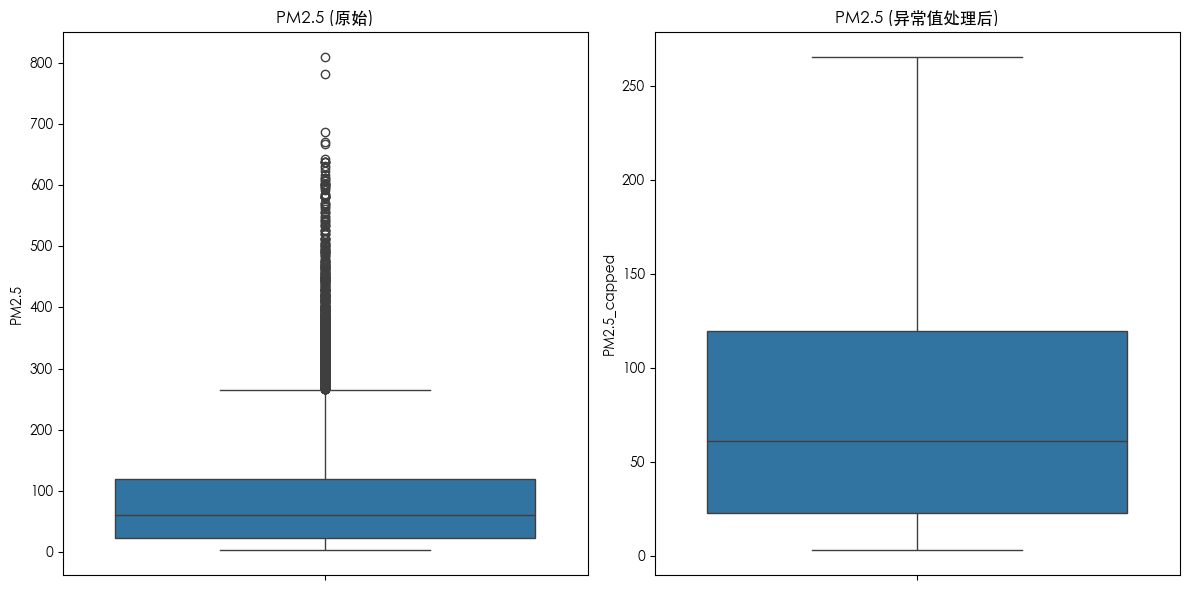

In [57]:
# 异常值处理 (以PM2.5为例)
Q1 = df['PM2.5'].quantile(0.25)
Q3 = df['PM2.5'].quantile(0.75)
IQR_value = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR_value
upper_bound = Q3 + 1.5 * IQR_value

# 上限替换法处理异常值
df['PM2.5_capped'] = np.where(df['PM2.5'] < lower_bound, lower_bound, df['PM2.5'])
df['PM2.5_capped'] = np.where(df['PM2.5_capped'] > upper_bound, upper_bound, df['PM2.5_capped'])

# 绘制PM2.5处理前后的箱线图对比
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['PM2.5'])
plt.title('PM2.5 (原始)')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['PM2.5_capped'])
plt.title('PM2.5 (异常值处理后)')
plt.tight_layout()
plt.show()

In [58]:
# 对WD进行独热编码
# 将要编码的列名 'WD' 放入一个列表中，并赋值给 columns 参数
df = pd.get_dummies(df, columns=['WD'], prefix='WD')


主要变量的描述性统计:
              PM2.5          PM10           SO2           NO2            O3  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean      88.588333    117.465066     20.343176     60.273302     60.324912   
std       90.886055    100.246098     26.678672     37.849882     61.095408   
min        3.000000      3.000000      2.000000      2.000000      1.000000   
25%       23.000000     42.000000      3.000000     30.000000      9.000000   
50%       61.000000     93.000000     10.000000     53.000000     45.000000   
75%      120.000000    161.000000     25.000000     83.000000     87.000000   
max      809.000000    907.000000    208.000000    265.000000    367.000000   

                 CO          TEMP          PRES          RAIN          HUMI  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean       1.368219     13.654895   1012.663802      0.063539     53.534582   
std        1.311389     11.412539     

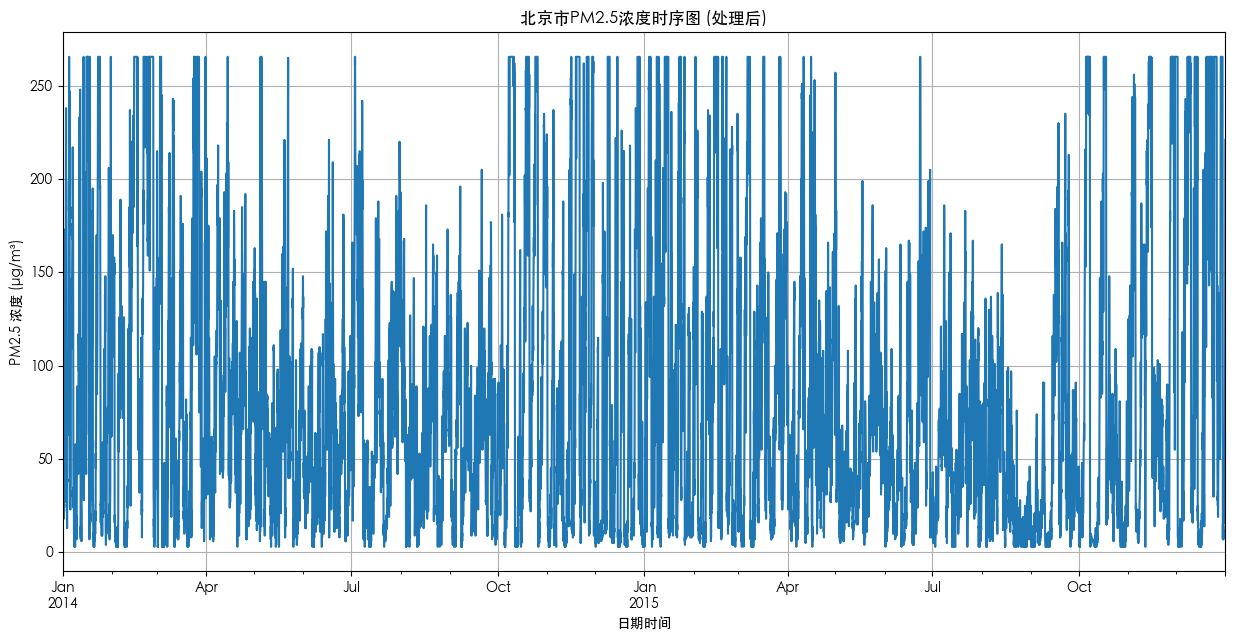

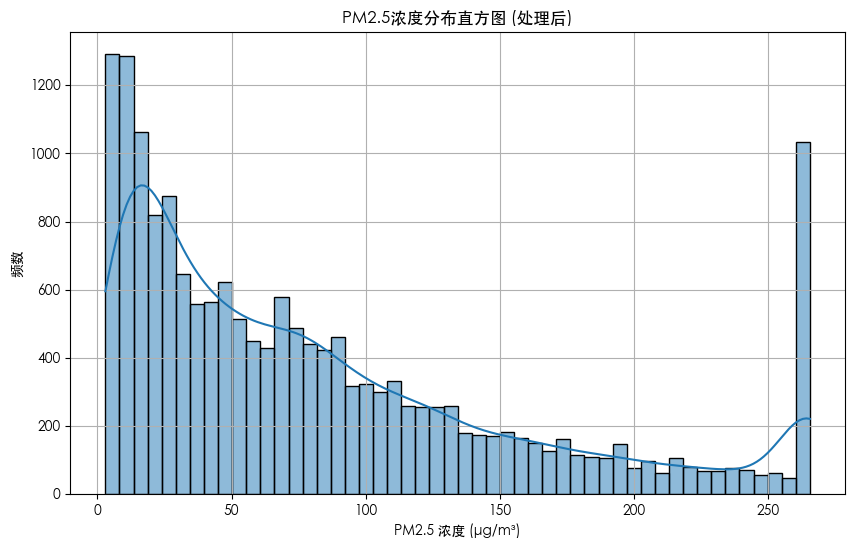

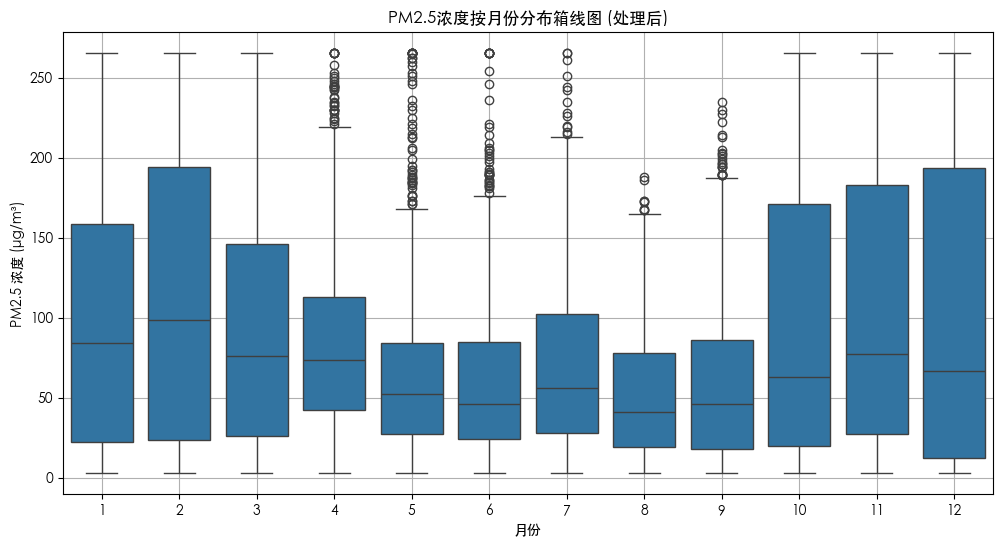

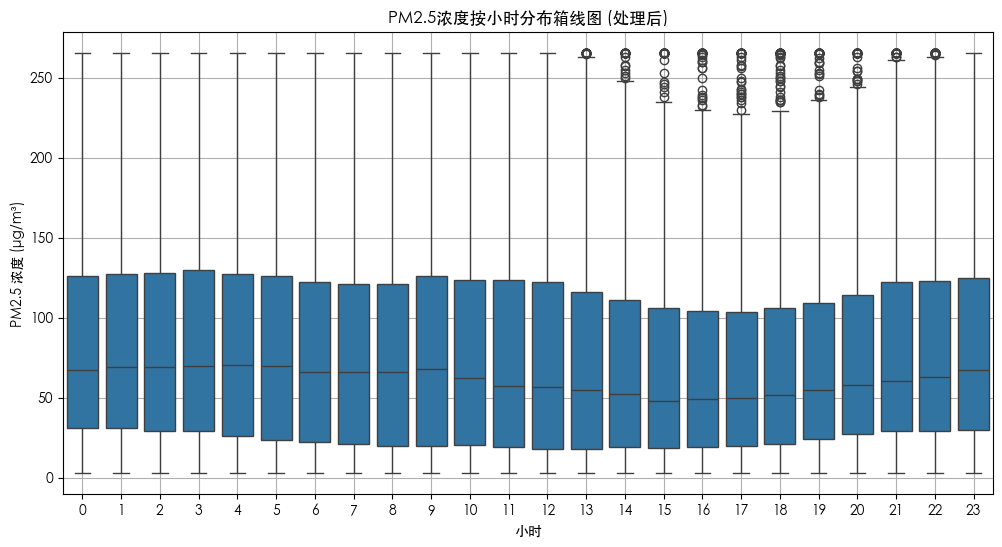

Text(0.5, 1.0, '主要空气质量及气象参数相关性热力图')

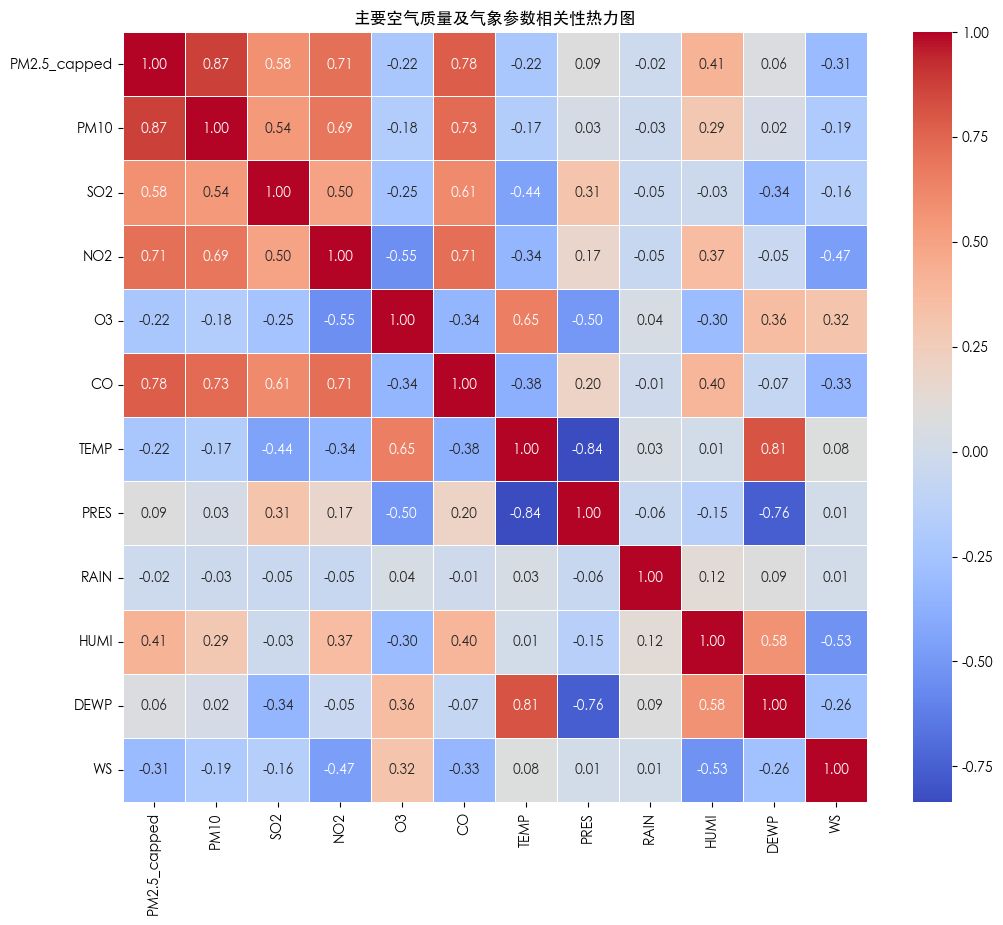

In [59]:


# 计算主要变量的描述性统计
desc_stats = df.describe()
print("\n主要变量的描述性统计:")
print(desc_stats)

# 可视化分析
# PM2.5_capped的时间序列图
plt.figure(figsize=(15, 7))
df['PM2.5_capped'].plot()
plt.title('北京市PM2.5浓度时序图 (处理后)')
plt.xlabel('日期时间')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.grid(True)
plt.show()

# PM2.5_capped的直方图
plt.figure(figsize=(10, 6))
sns.histplot(df['PM2.5_capped'], kde=True, bins=50)
plt.title('PM2.5浓度分布直方图 (处理后)')
plt.xlabel('PM2.5 浓度 (µg/m³)')
plt.ylabel('频数')
plt.grid(True)
plt.show()

# PM2.5_capped 按月份的箱线图
plt.figure(figsize=(12, 6))
sns.boxplot(x=df.index.month, y=df['PM2.5_capped'])
plt.title('PM2.5浓度按月份分布箱线图 (处理后)')
plt.xlabel('月份')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.grid(True)
plt.show()

# PM2.5_capped 按小时的箱线图
plt.figure(figsize=(12, 6))
sns.boxplot(x=df.index.hour, y=df['PM2.5_capped'])
plt.title('PM2.5浓度按小时分布箱线图 (处理后)')
plt.xlabel('小时')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.grid(True)
plt.show()

# ======== 这是修正的部分 ========
# 计算相关性矩阵 (仅选取部分数值型变量)
# 在下方列表中定义您希望分析相关性的列
correlation_cols = [
    'PM2.5_capped', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 
    'TEMP', 'PRES', 'RAIN', 'HUMI', 'DEWP', 'WS'
]

# 确保所有选定列都存在于DataFrame中
existing_correlation_cols = [col for col in correlation_cols if col in df.columns]
correlation_matrix = df[existing_correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('主要空气质量及气象参数相关性热力图')


/var/folders/82/tk3_mrrj641gqh1n1cbr4brr0000gn/T/ipykernel_34167/3144727506.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pm25_series_capped.fillna(method='ffill', inplace=True)
/var/folders/82/tk3_mrrj641gqh1n1cbr4brr0000gn/T/ipykernel_34167/3144727506.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pm25_series_capped.fillna(method='bfill', inplace=True)


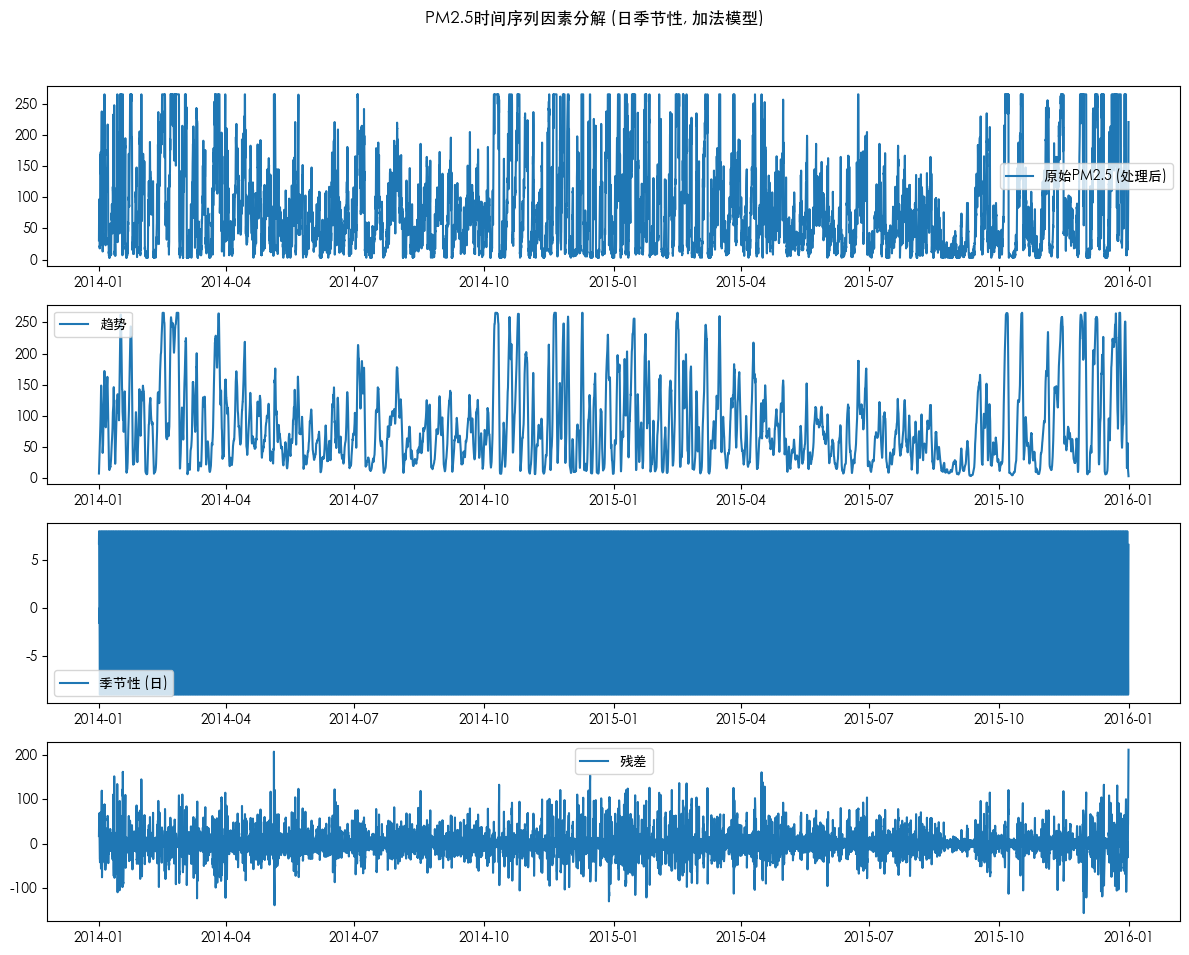

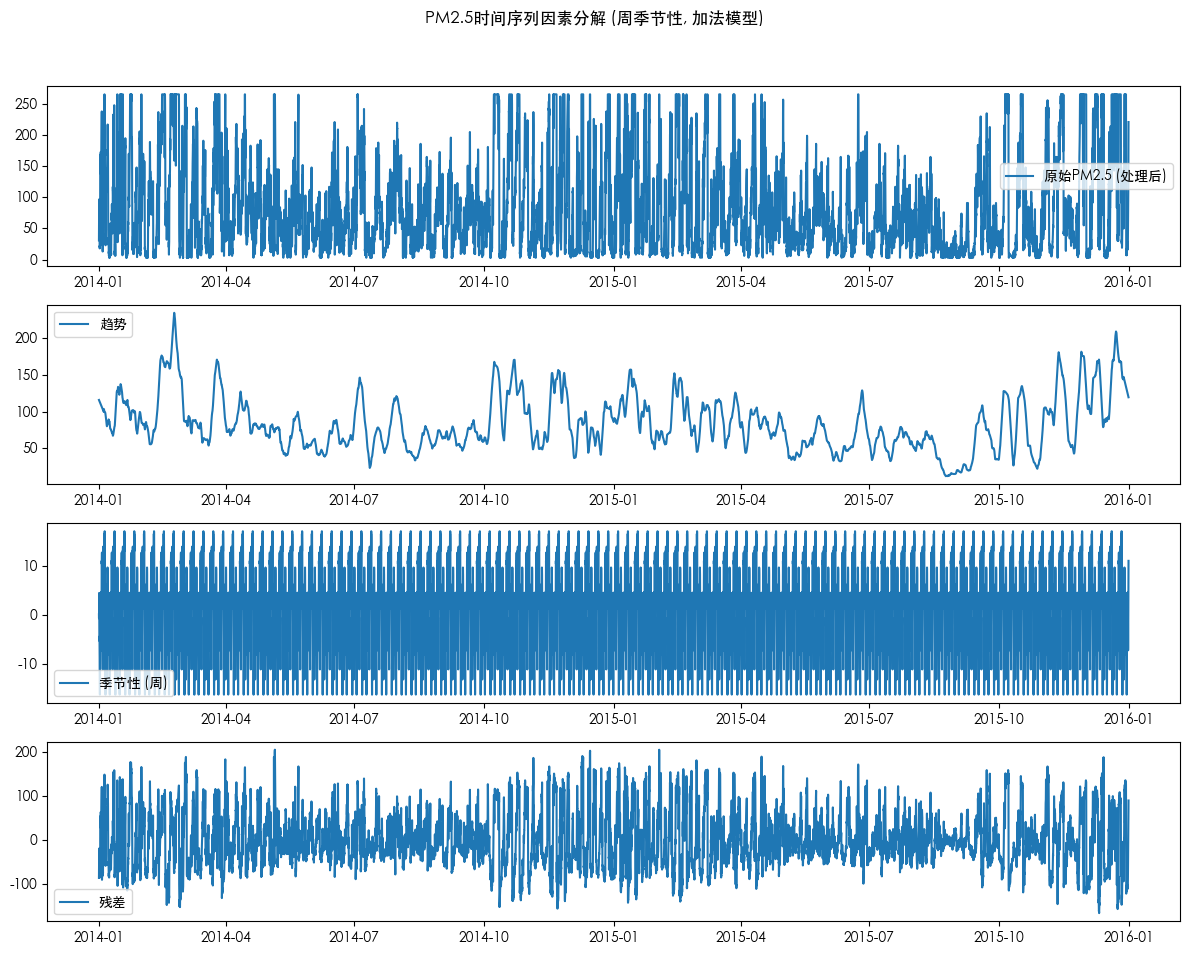

In [60]:
# 使用处理后的PM2.5数据进行分解
pm25_series_capped = df['PM2.5_capped'].copy()

# 确保数据没有NaN值，否则分解会出问题
pm25_series_capped.fillna(method='ffill', inplace=True)
pm25_series_capped.fillna(method='bfill', inplace=True)

# 尝试对数变换以稳定方差（如果季节性波动与趋势成比例）
# pm25_series_log = np.log(pm25_series_capped + 1) # 加1避免log(0)

# 每日季节性分解 (周期为24小时)
# 如果数据量不足以覆盖两个完整周期，seasonal_decompose会报错
# 假设我们至少有48小时的数据
if len(pm25_series_capped) >= 2*24:
    decomposition_daily = seasonal_decompose(pm25_series_capped, model='additive', period=24, extrapolate_trend='freq')
    
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(pm25_series_capped, label='原始PM2.5 (处理后)')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition_daily.trend, label='趋势')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition_daily.seasonal, label='季节性 (日)')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition_daily.resid, label='残差')
    plt.legend(loc='best')
    plt.suptitle('PM2.5时间序列因素分解 (日季节性, 加法模型)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("数据量不足以进行日季节性分解 (需要至少48个数据点)。")

# 每周季节性分解 (周期为24*7=168小时)
# 假设我们至少有2*168小时的数据
if len(pm25_series_capped) >= 2*168:
    decomposition_weekly = seasonal_decompose(pm25_series_capped, model='additive', period=168, extrapolate_trend='freq')

    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(pm25_series_capped, label='原始PM2.5 (处理后)')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition_weekly.trend, label='趋势')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition_weekly.seasonal, label='季节性 (周)')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition_weekly.resid, label='残差')
    plt.legend(loc='best')
    plt.suptitle('PM2.5时间序列因素分解 (周季节性, 加法模型)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("数据量不足以进行周季节性分解 (需要至少336个数据点)。")

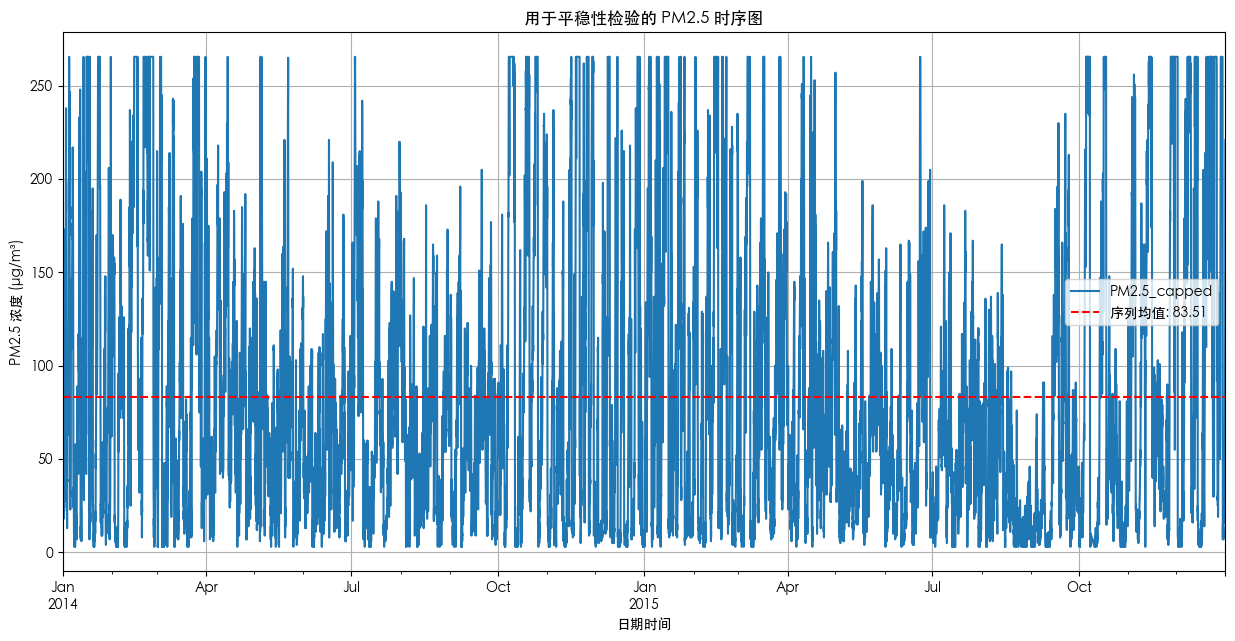


--- 可视化分析指南 ---
请观察上图：
1. 红色虚线代表整个序列的平均值。
2. 序列是否围绕着这条红线上下波动，而不是呈现出持续向上或向下的“大趋势”？
3. 如果序列没有长期、单向的趋势（即它看起来是“均值回归”的），那么它很可能被 ADF 检验判断为平稳，即 d=0。
   这在经过极值处理（capped）或分析周期内无明显政策/环境剧变的 PM2.5 数据中是常见的。


--- ADF 统计检验结果 ---
原始序列 ADF 统计量: -15.8184
原始序列 p-value: 1.0271355542351398e-28
临界值 (Critical Values):
	1%: -3.4307
	5%: -2.8617
	10%: -2.5669

结论：原始序列在统计上是平稳的。

最终确定的差分阶数 d = 0

正在为 d=0 的序列绘制ACF和PACF图...


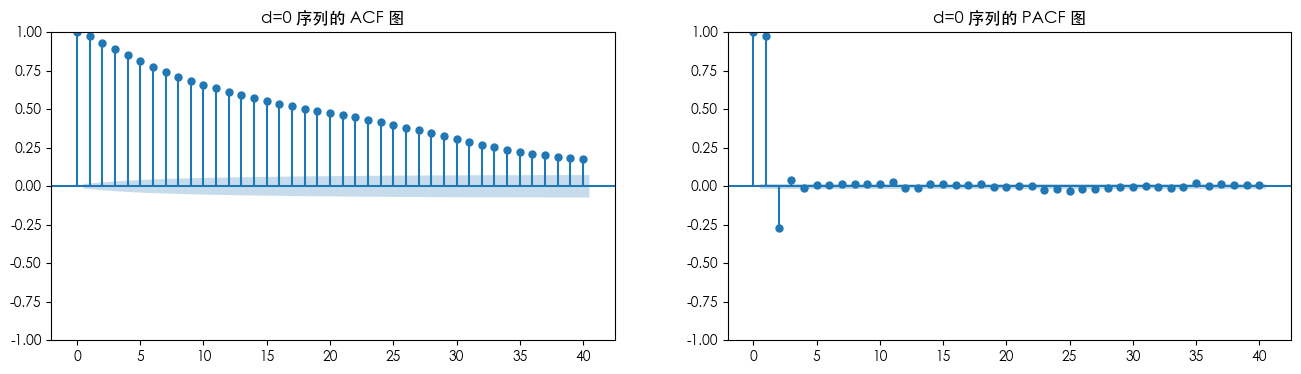

In [76]:
# --- 1. 可视化验证 (最重要的步骤) ---
# 在进行统计检验之前，先用肉眼观察序列的形态。
# 寻找是否存在一个贯穿始终的、明显的上升或下降趋势。
plt.figure(figsize=(15, 7))
pm25_series_capped.plot()
plt.title('用于平稳性检验的 PM2.5 时序图')
plt.xlabel('日期时间')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.grid(True)
plt.axhline(y=pm25_series_capped.mean(), color='r', linestyle='--', label=f'序列均值: {pm25_series_capped.mean():.2f}')
plt.legend()
plt.show()

print("""
--- 可视化分析指南 ---
请观察上图：
1. 红色虚线代表整个序列的平均值。
2. 序列是否围绕着这条红线上下波动，而不是呈现出持续向上或向下的“大趋势”？
3. 如果序列没有长期、单向的趋势（即它看起来是“均值回归”的），那么它很可能被 ADF 检验判断为平稳，即 d=0。
   这在经过极值处理（capped）或分析周期内无明显政策/环境剧变的 PM2.5 数据中是常见的。
""")


# --- 2. ADF 统计检验 ---
# 准备用于ARIMA模型的数据
arima_series = pm25_series_capped.dropna()

# ADF检验判断平稳性
# adfuller() 返回一个元组，我们需要的是第二个元素 (p-value)
adf_result = adfuller(arima_series)
print("\n--- ADF 统计检验结果 ---")
print(f'原始序列 ADF 统计量: {adf_result[0]:.4f}')
print(f'原始序列 p-value: {adf_result[1]}') # p-value通常非常小，会以科学记数法显示
print("临界值 (Critical Values):")
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.4f}')


# --- 3. 确定差分阶数 d ---
d = 0
temp_series = arima_series.copy() # 用于后续ACF/PACF绘图的序列

# 仅当 p-value > 0.05 时，才认为序列非平稳，需要差分
if adf_result[1] > 0.05:
    print("\n结论：原始序列非平稳，开始进行差分...")
    temp_series = temp_series.diff().dropna()
    d = 1
    adf_result_diff1 = adfuller(temp_series)
    print(f'一阶差分后 ADF 统计量: {adf_result_diff1[0]:.4f}')
    print(f'一阶差分后 p-value: {adf_result_diff1[1]}')
    
    if adf_result_diff1[1] > 0.05:
        print("\n结论：一阶差分后仍非平稳，进行二阶差分...")
        temp_series = temp_series.diff().dropna()
        d = 2
        adf_result_diff2 = adfuller(temp_series)
        print(f'二阶差分后 ADF 统计量: {adf_result_diff2[0]:.4f}')
        print(f'二阶差分后 p-value: {adf_result_diff2[1]}')
else:
    print("\n结论：原始序列在统计上是平稳的。")

print(f"\n最终确定的差分阶数 d = {d}")


# --- 4. 绘制 ACF 和 PACF 图 ---
# 如果 d=0, ACF/PACF图是基于原始序列绘制的。
# 如果 d>0, ACF/PACF图是基于最终差分后的序列绘制的。
print(f"\n正在为 d={d} 的序列绘制ACF和PACF图...")
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(temp_series, ax=axes[0], lags=40)
axes[0].set_title(f'd={d} 序列的 ACF 图')

plot_pacf(temp_series, ax=axes[1], lags=40)
axes[1].set_title(f'd={d} 序列的 PACF 图')

plt.show()



In [ ]:
# --- 假设以下变量已从前面的步骤中获取 ---
# arima_series: 用于建模的时间序列 (pd.Series)
# d: 差分阶数 (int)
# p_order, q_order: 模型的p和q阶数 (int)

# 划分训练集和测试集
train_size = int(len(arima_series) * 0.8)
train, test = arima_series[0:train_size], arima_series[train_size:len(arima_series)]

# 拟合ARIMA模型
try:
    model_arima = ARIMA(train, order=(p_order, d, q_order))
    model_arima_fit = model_arima.fit()
    print("--- ARIMA Model Summary ---")
    print(model_arima_fit.summary())
    
    # --- 1. 自动解析模型系数和p-value (这是新增的逻辑) ---
    
    # 将摘要的第二个表格转换为DataFrame
    results_summary_df = pd.DataFrame(model_arima_fit.summary().tables[1].data)
    # 将第一行设置为列名
    results_summary_df.columns = results_summary_df.iloc[0]
    # 删除作为列名的第一行
    results_summary_df = results_summary_df.drop(0)
    # 将第一列（变量名）设置为主索引
    results_summary_df = results_summary_df.set_index(results_summary_df.columns[0])
    
    # 选择我们需要的列，并将它们转换为数值类型
    results_summary_df = results_summary_df[['coef', 'P>|z|']].astype(float)
    
    # 提取AR和MA系数的格式化字符串
    ar_strings = []
    ma_strings = []
    
    for index, row in results_summary_df.iterrows():
        # 检查索引是否以 'ar.L' 开头
        if str(index).strip().startswith('ar.L'):
            ar_strings.append(f"{index.strip()}: {row['coef']:.3f} (p={row['P>|z|']:.3f})")
        # 检查索引是否以 'ma.L' 开头
        elif str(index).strip().startswith('ma.L'):
            ma_strings.append(f"{index.strip()}: {row['coef']:.3f} (p={row['P>|z|']:.3f})")

    # 如果没有找到对应的系数（例如p=0或q=0），则显示 "N/A"
    ar_coeffs_pvals = "\n".join(ar_strings) if ar_strings else "N/A"
    ma_coeffs_pvals = "\n".join(ma_strings) if ma_strings else "N/A"

    # --- 2. 填充摘要表格 ---
    order_str = f"({p_order},{d},{q_order})"
    log_likelihood = model_arima_fit.llf
    aic = model_arima_fit.aic
    bic = model_arima_fit.bic
    hqic = model_arima_fit.hqic
 
    arima_summary_data = {
        'Parameter': [
            "ARIMA Order (p,d,q)",
            "AR Coefficients (p-values)",
            "MA Coefficients (p-values)",
            "Log Likelihood",
            "AIC",
            "BIC",
            "HQIC"
        ],
        'Value': [
            order_str, 
            ar_coeffs_pvals,  # <--- 使用自动解析的结果
            ma_coeffs_pvals,  # <--- 使用自动解析的结果
            f"{log_likelihood:.3f}", 
            f"{aic:.3f}", 
            f"{bic:.3f}", 
            f"{hqic:.3f}"
        ]
    }
    
    arima_summary_table = pd.DataFrame(arima_summary_data)
    print("\n--- Table 3: ARIMA Model Parameters and Goodness-of-Fit Statistics (Auto-filled) ---")
    print(arima_summary_table.to_string(index=False))

except Exception as e:
    print(f"ARIMA模型拟合失败: {e}")
    model_arima_fit = None


/Users/hanxiaoyu/Downloads/time serios homework/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/hanxiaoyu/Downloads/time serios homework/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/hanxiaoyu/Downloads/time serios homework/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/hanxiaoyu/Downloads/time serios homework/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/hanxiaoyu/Downloads/time serios homework/.venv/lib/python3.12/

--- ARIMA Model Summary ---
                               SARIMAX Results                                
Dep. Variable:           PM2.5_capped   No. Observations:                14016
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -59615.938
Date:                Mon, 09 Jun 2025   AIC                         119239.876
Time:                        23:23:32   BIC                         119270.068
Sample:                    01-01-2014   HQIC                        119249.927
                         - 08-07-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3319      5.015     16.618      0.000      73.503      93.160
ar.L1          0.9542      0.003    312.808      0.000       0.948       0.960
ma.L1          0.2666   

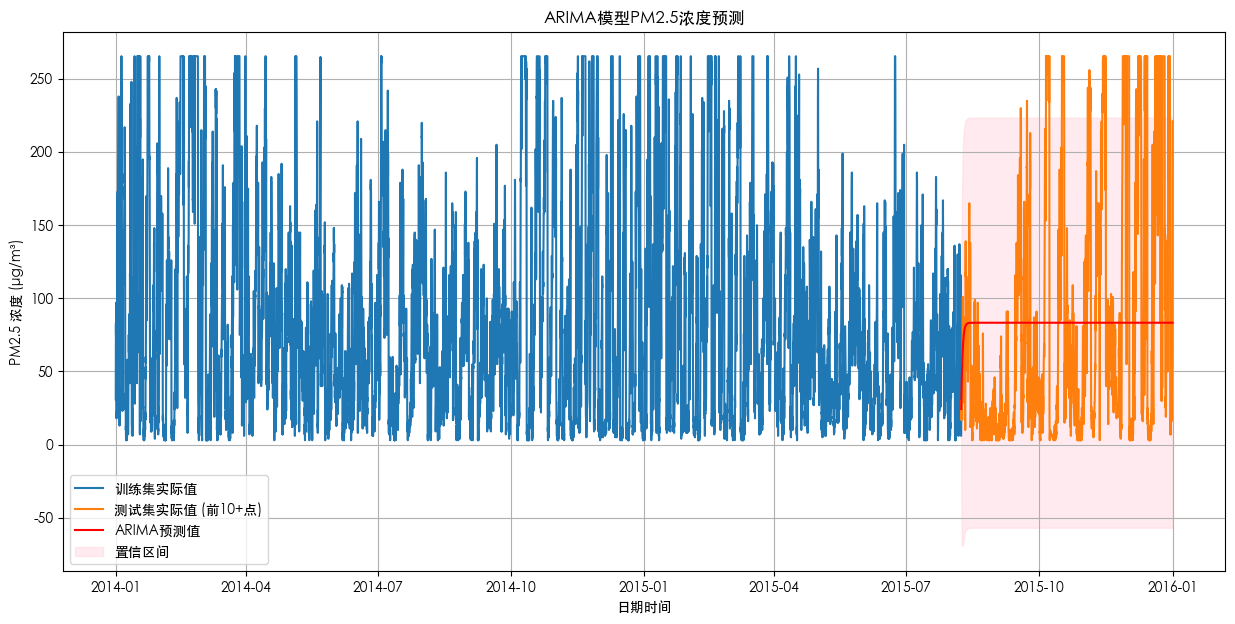

ARIMA 预测 RMSE: 86.133
ARIMA 预测 MAE: 70.776


In [81]:
if model_arima_fit:
    # 预测未来至少10个点
    forecast_steps = max(10, len(test)) # 预测整个测试集或至少10个点
    
    #.predict()方法用于样本内和样本外的预测
    #.forecast()方法更常用于样本外预测
    forecast_results = model_arima_fit.get_forecast(steps=forecast_steps)
    forecast_values = forecast_results.predicted_mean
    confidence_intervals = forecast_results.conf_int()

    # 确保forecast_values的索引与test的前forecast_steps个点对齐
    if len(test) >= forecast_steps:
        test_subset_for_eval = test.iloc[:forecast_steps]
        forecast_values.index = test_subset_for_eval.index
        if confidence_intervals is not None:
            confidence_intervals.index = test_subset_for_eval.index
    else: # 如果测试集不够长，则预测超出现有测试集
        last_train_date = train.index[-1]
        forecast_index = pd.date_range(start=last_train_date, periods=forecast_steps + 1, freq=train.index.freq)[1:]
        forecast_values.index = forecast_index
        if confidence_intervals is not None:
            confidence_intervals.index = forecast_index
        test_subset_for_eval = test # 评估时仍用整个测试集，但绘图可能只显示预测部分
        print("警告: 预测步数超过测试集长度，部分预测为纯未来值。")


    # 可视化预测结果
    plt.figure(figsize=(15, 7))
    plt.plot(train.index, train, label='训练集实际值')
    if len(test_subset_for_eval) > 0 : # 只有当测试子集非空时才绘制
        plt.plot(test_subset_for_eval.index, test_subset_for_eval, label='测试集实际值 (前10+点)')
    plt.plot(forecast_values.index, forecast_values, label='ARIMA预测值', color='red')
    if confidence_intervals is not None and len(test_subset_for_eval) > 0:
        plt.fill_between(confidence_intervals.index,
                         confidence_intervals.iloc[:, 0],
                         confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='置信区间')
    plt.title('ARIMA模型PM2.5浓度预测')
    plt.xlabel('日期时间')
    plt.ylabel('PM2.5 浓度 (µg/m³)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 评估预测效果 (仅对测试集中有对应预测值的部分进行)
    actual_for_eval = test_subset_for_eval if len(test_subset_for_eval) <= len(forecast_values) else test.iloc[:len(forecast_values)]
    predicted_for_eval = forecast_values.iloc[:len(actual_for_eval)]
    
    if len(actual_for_eval) > 0 and len(predicted_for_eval) > 0:
        rmse_arima = np.sqrt(mean_squared_error(actual_for_eval, predicted_for_eval))
        mae_arima = mean_absolute_error(actual_for_eval, predicted_for_eval)
        print(f'ARIMA 预测 RMSE: {rmse_arima:.3f}')
        print(f'ARIMA 预测 MAE: {mae_arima:.3f}')
    else:
        print("无法计算ARIMA的RMSE和MAE，因为没有足够的重叠数据进行评估。")
        rmse_arima, mae_arima = np.nan, np.nan
else:
    print("ARIMA模型未成功拟合，跳过预测与评估。")
    rmse_arima, mae_arima = np.nan, np.nan

X_train shape: (12240, 24, 1), y_train shape: (12240, 10)
X_val shape: (2623, 24, 1), y_val shape: (2623, 10)
X_test shape: (2624, 24, 1), y_test shape: (2624, 10)


/Users/hanxiaoyu/Downloads/time serios homework/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0825 - val_loss: 0.0151
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0347 - val_loss: 0.0144
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0308 - val_loss: 0.0125
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0324 - val_loss: 0.0140
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0301 - val_loss: 0.0138
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0309 - val_loss: 0.0122
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0294 - val_loss: 0.0144
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0298 - val_loss: 0.0122
Epoch 9/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0288 - val_loss: 0.0124
Epoch 10/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0306 - val_loss: 0.0137
Epoch 11/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0132
Epoch 12/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

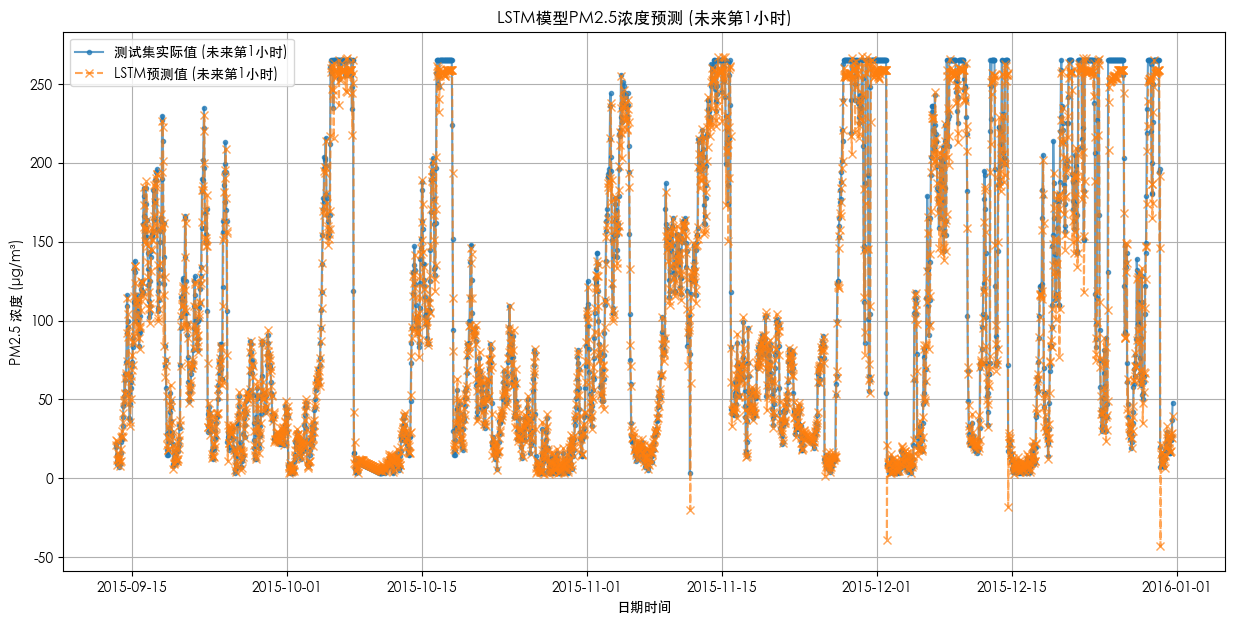

In [ ]:


# --- 1. 数据准备 ---
# 使用 'PM2.5_capped' 作为目标变量
pm25_data_lstm = df[['PM2.5_capped']].copy()

# 数据缩放 (归一化到0-1范围)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pm25_data_lstm)

# 创建时间序列样本的函数
def create_sequences(data, n_past, n_future):
    X, y = [], [] # <--- 修正 #1: 初始化为空列表
    for i in range(len(data) - n_past - n_future + 1):
        X.append(data[i : i + n_past, 0])
        y.append(data[i + n_past : i + n_past + n_future, 0])
    return np.array(X), np.array(y)

# 定义序列长度
n_past = 24  # 使用过去24小时的数据
n_future = 10 # 预测未来10小时的数据
X, y = create_sequences(scaled_data, n_past, n_future)

# 划分训练集、验证集和测试集
# 70%训练, 15%验证, 15%测试
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# LSTM输入需要是 [samples, timesteps, features]
# <--- 修正 #2: 修正reshape的参数
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- 2. 构建并训练LSTM模型 ---
# <--- 修正 #3: 向模型中添加必需的层
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(n_past, 1)),
    Dense(n_future)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

# 定义回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)

# 训练模型
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint],
                              verbose=1)

# --- 3. 评估模型 ---
# 加载在验证集上表现最佳的模型进行最终预测
best_model_lstm = tf.keras.models.load_model('best_lstm_model.keras')

# 在测试集上进行预测
predictions_lstm_scaled = best_model_lstm.predict(X_test)
# 将预测结果和真实值反归一化
predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled)
actual_lstm = scaler.inverse_transform(y_test)

# 计算所有10个预测时间步的平均RMSE和MAE
# <--- 修正 #4: 初始化为空列表
rmse_lstm_all_steps = []
mae_lstm_all_steps = []
for i in range(n_future):
    rmse_i = np.sqrt(mean_squared_error(actual_lstm[:, i], predictions_lstm[:, i]))
    mae_i = mean_absolute_error(actual_lstm[:, i], predictions_lstm[:, i])
    rmse_lstm_all_steps.append(rmse_i)
    mae_lstm_all_steps.append(mae_i)
    print(f'LSTM 预测 (未来第{i+1}小时) RMSE: {rmse_i:.3f}, MAE: {mae_i:.3f}')

rmse_lstm = np.mean(rmse_lstm_all_steps)
mae_lstm = np.mean(mae_lstm_all_steps)
print(f'\nLSTM 预测 (未来10小时平均) RMSE: {rmse_lstm:.3f}')
print(f'LSTM 预测 (未来10小时平均) MAE: {mae_lstm:.3f}')


# --- 4. 可视化预测结果 ---
# <--- 修正 #5: 优化日期对齐逻辑
# 计算测试集在原始数据中的起始索引
test_start_index = train_size + val_size + n_past
# 获取测试集对应的日期索引
test_dates = pm25_data_lstm.index[test_start_index : test_start_index + len(X_test)]

# 以第一个预测点为例进行可视化
plt.figure(figsize=(15, 7))
plt.plot(test_dates, actual_lstm[:, 0], label='测试集实际值 (未来第1小时)', marker='.', alpha=0.7)
plt.plot(test_dates, predictions_lstm[:, 0], label='LSTM预测值 (未来第1小时)', marker='x', linestyle='--', alpha=0.7)
plt.title('LSTM模型PM2.5浓度预测 (未来第1小时)')
plt.xlabel('日期时间')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding (Dense)   │ (None, 24, 64)    │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 64)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_0               │ (None, 24, 64)    │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 64)    │          0 │ mha_0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24, 64)    │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 64)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_1               │ (None, 24, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 64)    │          0 │ mha_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 24, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 24, 64)    │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 24, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0] 

 Total params: 176,138 (688.04 KB)

 Trainable params: 176,138 (688.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0751 - val_loss: 0.0133
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0345 - val_loss: 0.0136
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0316 - val_loss: 0.0204
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0328 - val_loss: 0.0130
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0312 - val_loss: 0.0117
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0310 - val_loss: 0.0130
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0313 - val_loss: 0.0134
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0291 - val_loss: 0.0148
Epoch 9/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0307 - val_loss: 0.0125
Epoch 10/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0299 - val_loss: 0.0124
Epoch 11/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0293 - val_loss: 0.0129
Epoch 12/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 

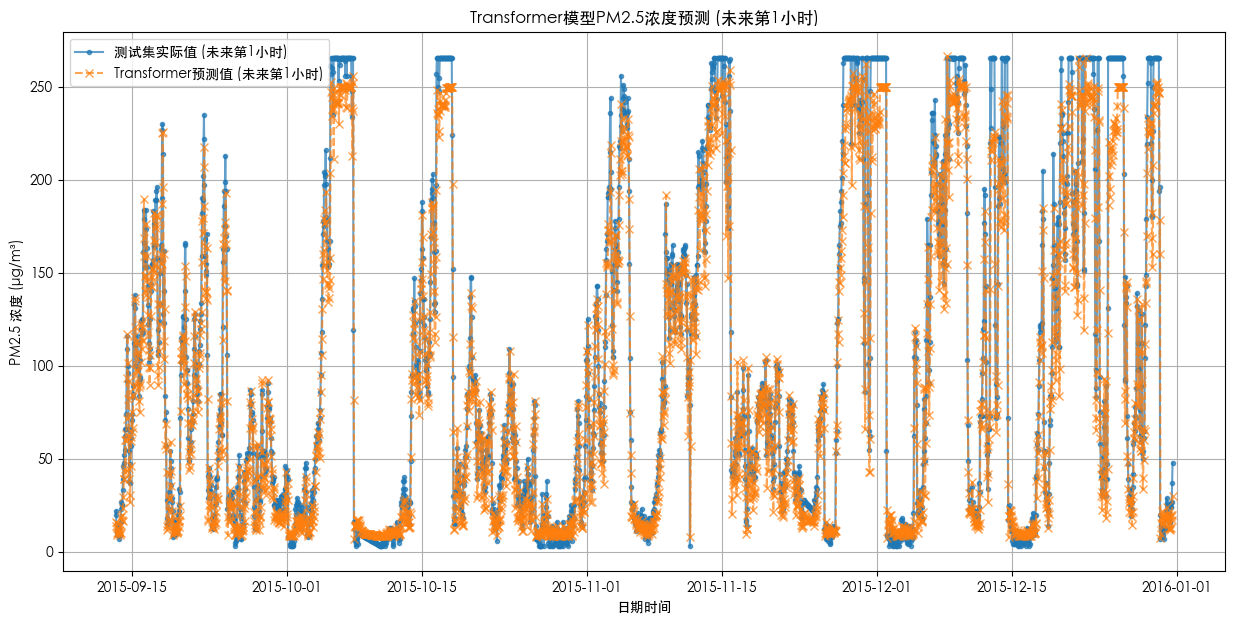

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 中文字体设置 ---
# 确保您已经按照之前的方法设置好了中文字体
plt.rcParams['font.sans-serif'] = ['STHeiti'] # 或者 'PingFang SC', 'Heiti TC' 等
plt.rcParams['axes.unicode_minus'] = False

# --- 数据准备 ---
# 假设 X_train, y_train, X_val, y_val, X_test, y_test, scaler, n_past, n_future, test_dates
# 这些变量都已在之前的 LSTM 步骤中准备好并可用。

# --- 1. Transformer 模型构建 ---

# 位置编码 (Positional Encoding)
def get_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# 模型超参数
d_model = 64
num_heads = 4
num_encoder_layers = 2
dff = 128
dropout_rate = 0.1

# 输入层
inputs = Input(shape=(n_past, 1))

# 嵌入层 (简单线性层) + 位置编码
embedding_layer = Dense(d_model, name='embedding')
x = embedding_layer(inputs)
pos_encoding = get_positional_encoding(n_past, d_model)
x += pos_encoding

# Transformer 编码器层 (Encoder Layers)
for i in range(num_encoder_layers):
    # 多头注意力机制
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, name=f'mha_{i}')(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    
    # 前馈神经网络
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# 输出层
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(n_future, name='output_layer')(x)

# 创建并编译模型
model_transformer = Model(inputs=inputs, outputs=outputs)
model_transformer.compile(optimizer='adam', loss='mse')
model_transformer.summary()


# --- 2. 训练模型 ---
early_stopping_transformer = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_transformer = ModelCheckpoint('best_transformer_model.keras', monitor='val_loss', save_best_only=True)

history_transformer = model_transformer.fit(X_train, y_train, epochs=50, batch_size=32,
                                          validation_data=(X_val, y_val),
                                          callbacks=[early_stopping_transformer, model_checkpoint_transformer],
                                          verbose=1)


# --- 3. 评估模型 ---
# 加载在验证集上表现最佳的模型
best_model_transformer = tf.keras.models.load_model('best_transformer_model.keras')

# 在测试集上预测
predictions_transformer_scaled = best_model_transformer.predict(X_test)
# 反归一化
predictions_transformer = scaler.inverse_transform(predictions_transformer_scaled)
# y_test在LSTM部分已经反归一化过了，这里我们重新获取以确保一致
actual_transformer = scaler.inverse_transform(y_test)

# 计算每个预测时间步的RMSE和MAE
# <--- 修正 #1: 初始化为空列表
rmse_transformer_all_steps = []
mae_transformer_all_steps = []
for i in range(n_future):
    rmse_i = np.sqrt(mean_squared_error(actual_transformer[:, i], predictions_transformer[:, i]))
    mae_i = mean_absolute_error(actual_transformer[:, i], predictions_transformer[:, i])
    rmse_transformer_all_steps.append(rmse_i)
    mae_transformer_all_steps.append(mae_i)
    print(f'Transformer 预测 (未来第{i+1}小时) RMSE: {rmse_i:.3f}, MAE: {mae_i:.3f}')

# 计算平均误差
rmse_transformer = np.mean(rmse_transformer_all_steps)
mae_transformer = np.mean(mae_transformer_all_steps)
print(f'\nTransformer 预测 (未来10小时平均) RMSE: {rmse_transformer:.3f}')
print(f'Transformer 预测 (未来10小时平均) MAE: {mae_transformer:.3f}')


# --- 4. 可视化预测结果 ---
# 使用之前计算好的 test_dates 变量来对齐X轴
plt.figure(figsize=(15, 7))
plt.plot(test_dates, actual_transformer[:, 0], label='测试集实际值 (未来第1小时)', marker='.', alpha=0.7)
plt.plot(test_dates, predictions_transformer[:, 0], label='Transformer预测值 (未来第1小时)', marker='x', linestyle='--', alpha=0.7)
plt.title('Transformer模型PM2.5浓度预测 (未来第1小时)')
plt.xlabel('日期时间')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()



ARIMA (可比评估) RMSE: 86.133
ARIMA (可比评估) MAE: 70.776

Table 4: 各模型PM2.5预测性能指标比较
      Model RMSE (未来10小时平均) MAE (未来10小时平均)
      ARIMA          86.133         70.776
       LSTM          46.813         32.402
Transformer          48.119         33.885


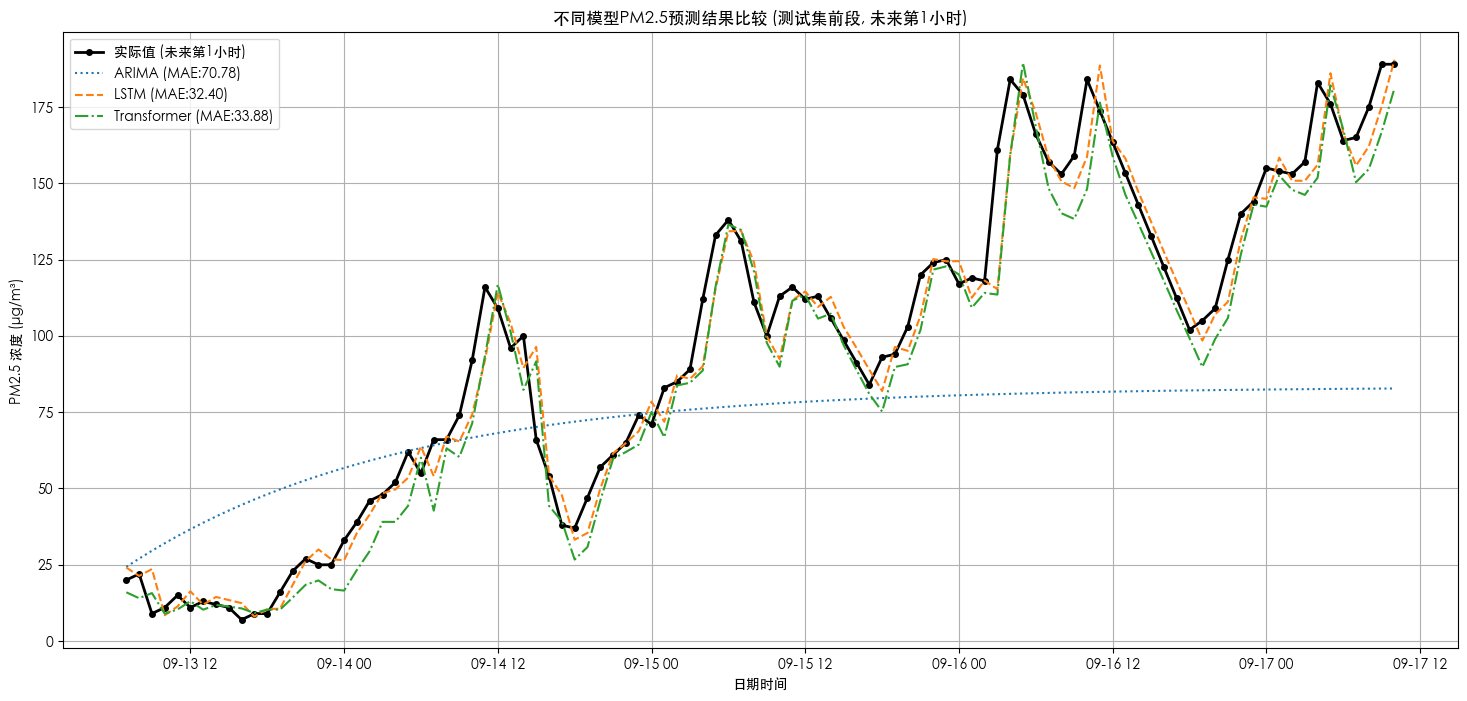

In [73]:

# model_arima_fit: 训练好的ARIMA模型
# forecast_values: ARIMA模型在测试集上的预测值 (pd.Series)
# test: ARIMA模型的测试集 (pd.Series)
# rmse_lstm, mae_lstm: LSTM模型的平均评估指标
# rmse_transformer, mae_transformer: Transformer模型的平均评估指标
# predictions_lstm, predictions_transformer: LSTM和Transformer的预测结果 (numpy array)
# actual_lstm: 测试集的真实值 (与LSTM/Transformer预测对应)
# test_dates: 用于绘图的测试集日期索引

# --- 1. 重新评估ARIMA模型，使其与深度学习模型可比 ---

# 初始化ARIMA评估指标为NaN，以防模型不存在或预测失败
rmse_arima_10step_avg = np.nan
mae_arima_10step_avg = np.nan

# 仅在ARIMA模型成功拟合并有预测值时才进行评估
if 'model_arima_fit' in locals() and model_arima_fit is not None and 'forecast_values' in locals():
    # 确保预测值和实际值的长度一致以进行比较
    num_eval_points = min(len(test), len(forecast_values))
    if num_eval_points > 0:
        actual_arima_eval = test.iloc[:num_eval_points]
        predicted_arima_eval = forecast_values.iloc[:num_eval_points]
        
        # 计算在整个可比测试集上的RMSE和MAE
        # 这可以作为与LSTM/Transformer的平均指标的一个近似比较
        rmse_arima_10step_avg = np.sqrt(mean_squared_error(actual_arima_eval, predicted_arima_eval))
        mae_arima_10step_avg = mean_absolute_error(actual_arima_eval, predicted_arima_eval)
        print(f"ARIMA (可比评估) RMSE: {rmse_arima_10step_avg:.3f}")
        print(f"ARIMA (可比评估) MAE: {mae_arima_10step_avg:.3f}")

# --- 2. 创建性能比较表格 ---

# <--- 修正 #1: 为'Model'键提供一个列表作为值
performance_data = {
    'Model': ['ARIMA', 'LSTM', 'Transformer'],
    'RMSE (未来10小时平均)': [
        f"{rmse_arima_10step_avg:.3f}" if not np.isnan(rmse_arima_10step_avg) else "N/A", 
        f"{rmse_lstm:.3f}" if 'rmse_lstm' in locals() and not np.isnan(rmse_lstm) else "N/A", 
        f"{rmse_transformer:.3f}" if 'rmse_transformer' in locals() and not np.isnan(rmse_transformer) else "N/A"
    ],
    'MAE (未来10小时平均)': [
        f"{mae_arima_10step_avg:.3f}" if not np.isnan(mae_arima_10step_avg) else "N/A", 
        f"{mae_lstm:.3f}" if 'mae_lstm' in locals() and not np.isnan(mae_lstm) else "N/A", 
        f"{mae_transformer:.3f}" if 'mae_transformer' in locals() and not np.isnan(mae_transformer) else "N/A"
    ]
}
performance_table = pd.DataFrame(performance_data)
print("\nTable 4: 各模型PM2.5预测性能指标比较")
print(performance_table.to_string(index=False))


# --- 3. 可视化比较 ---
# 取测试集中的一段进行详细比较，例如前100个样本的第一个未来预测点
plot_len = min(100, len(actual_lstm))
plot_dates = test_dates[:plot_len]

plt.figure(figsize=(18, 8))
# 绘制真实值
plt.plot(plot_dates, actual_lstm[:plot_len, 0], label='实际值 (未来第1小时)', color='black', linewidth=2, marker='o', markersize=4)

# 绘制ARIMA预测（如果有效）
# 注意：ARIMA的单步预测与LSTM/Transformer的第一个预测步是对齐的
if not np.isnan(mae_arima_10step_avg) and len(forecast_values) >= plot_len:
    plt.plot(plot_dates, forecast_values.iloc[:plot_len], label=f'ARIMA (MAE:{mae_arima_10step_avg:.2f})', linestyle=':')

# 绘制LSTM预测（如果有效）
if 'mae_lstm' in locals() and not np.isnan(mae_lstm):
    plt.plot(plot_dates, predictions_lstm[:plot_len, 0], label=f'LSTM (MAE:{mae_lstm:.2f})', linestyle='--')

# 绘制Transformer预测（如果有效）
if 'mae_transformer' in locals() and not np.isnan(mae_transformer):
    plt.plot(plot_dates, predictions_transformer[:plot_len, 0], label=f'Transformer (MAE:{mae_transformer:.2f})', linestyle='-.')

plt.title('不同模型PM2.5预测结果比较 (测试集前段, 未来第1小时)')
plt.xlabel('日期时间')
plt.ylabel('PM2.5 浓度 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()
